In [98]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import warnings
from dateutil.relativedelta import relativedelta
from datetime import datetime
warnings.filterwarnings('ignore')
import ast
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [99]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [100]:
import os
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/')
!ls

'Accuracy: 0.72_Resume_Screening_KNN.ipynb'
'Another copy of Resume Screening with KNN ML '
 Candidate_Recommending_System.ipynb
'Copy of final model of resume Sceening'
'Copy of final model of resume Sceening (1)'
'Copy of jobRecommender.ipynb'
'Copy of notebook8d9d15b57c'
'Copy of notebook97af9e7900'
'Copy of notebook97af9e7900 (1)'
'Copy of Resume Screening with KNN ML '
'Copy of Resume Screening with KNN ML  (1)'
'Copy of Resume Screening with KNN ML  (2)'
'Copy of Resume_Screening_with_NLP_prototype.ipynb'
'Copy of Updated_Resume_Screening_KNN.ipynb'
 correlation_matrix.png
 enhanced_job_recommendations.csv
'final model of resume Sceening.ipynb'
 Final_Resume_Screening_KNN.ipynb
'Iqra Mahmood Resume-5.pdf'
 job_recommendation_kmeans.csv
 job_recommendations_optimized.csv
 jobRecommender.ipynb
 Job_Requirement_Analysis_K_Means_Text_Clustering.ipynb
 Modified.csv
'Muhammad Murtza.pdf'
 MuhammadUsman.pdf
 M.Usman.pdf
 pone.0255419.s001.xlsx
 prediction_plot.png
 regression_results.pn

In [101]:
# Enhanced text preprocessing function
def enhanced_preprocess(text):
    if pd.isnull(text) or text == '':
        return ''

    # Text cleaning
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r'\@\w+|\#\w+', '', text) # Remove mentions/hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Keep only letters
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenization and lemmatization
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Remove short words and stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens
              if word not in stop_words and len(word) > 2]

    return ' '.join(tokens)

In [102]:
# Function to safely convert string representation of lists to actual lists
def safe_convert_to_list(x):
    if isinstance(x, str) and x.startswith('[') and x.endswith(']'):
        try:
            return ast.literal_eval(x)
        except:
            return [x]
    elif isinstance(x, list):
        return x
    else:
        return [x]


In [103]:
# Function to parse date string
def parse_date(date_str):
    try:
        if pd.isna(date_str) or date_str in ['', 'N/A']:
            return None
        if isinstance(date_str, str) and date_str.lower() in ['current', 'till date', 'present']:
            return datetime.now()
        return datetime.strptime(str(date_str), '%b %Y')
    except ValueError:
        try:
            return datetime.strptime(str(date_str), '%Y-%m-%d')
        except:
            return None


In [104]:
# Function to calculate experience in years
def calculate_experience(start_dates, end_dates):
    total_experience = 0

    # Convert inputs to lists if they aren't already
    start_dates = safe_convert_to_list(start_dates)
    end_dates = safe_convert_to_list(end_dates)

    # Ensure we have matching number of start and end dates
    num_periods = min(len(start_dates), len(end_dates))

    for i in range(num_periods):
        start_date = parse_date(start_dates[i])
        end_date = parse_date(end_dates[i])

        if start_date and end_date:
            # Ensure end date is after start date
            if end_date < start_date:
                continue

            delta = relativedelta(end_date, start_date)
            total_experience += delta.years + delta.months/12 + delta.days/365

    return round(total_experience, 2)

In [105]:
import pandas as pd
df = pd.read_csv('resume_data.csv', encoding='utf-8-sig')
print(df.columns)

Index(['address', 'career_objective', 'skills', 'educational_institution_name',
       'degree_names', 'passing_years', 'educational_results', 'result_types',
       'major_field_of_studies', 'professional_company_names', 'company_urls',
       'start_dates', 'end_dates', 'related_skils_in_job', 'positions',
       'locations', 'responsibilities', 'extra_curricular_activity_types',
       'extra_curricular_organization_names',
       'extra_curricular_organization_links', 'role_positions', 'languages',
       'proficiency_levels', 'certification_providers', 'certification_skills',
       'online_links', 'issue_dates', 'expiry_dates', 'job_position_name',
       'educationaL_requirements', 'experiencere_requirement',
       'age_requirement', 'responsibilities.1', 'skills_required',
       'matched_score'],
      dtype='object')


In [106]:
# Calculate experience for each candidate
print("Calculating work experience for each candidate...")
df['Experience_Years'] = df.apply(lambda x: calculate_experience(x['start_dates'], x['end_dates']), axis=1)


Calculating work experience for each candidate...


In [107]:
# Display experience distribution
print("\nExperience Distribution:")
print(df['Experience_Years'].describe())


Experience Distribution:
count    9544.000000
mean        2.078311
std         5.627393
min         0.000000
25%         0.000000
50%         0.000000
75%         1.080000
max        51.690000
Name: Experience_Years, dtype: float64


In [108]:
# def preprocess_text(text):
#     if pd.isnull(text):
#         return ''
#     text = text.lower()
#     text = re.sub(r'[^a-zA-Z\s]', '', text)
#     tokens = nltk.word_tokenize(text)
#     tokens = [WordNetLemmatizer().lemmatize(word) for word in tokens if word not in stopwords.words('english')]
#     return ' '.join(tokens)
df.head()

,address,career_objective,skills,educational_institution_name,degree_names,passing_years,educational_results,result_types,major_field_of_studies,professional_company_names,...,issue_dates,expiry_dates,job_position_name,educationaL_requirements,experiencere_requirement,age_requirement,responsibilities.1,skills_required,matched_score,Experience_Years
0,NaN,Big data analytics working and database wareho...,"['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapr...",['The Amity School of Engineering & Technology...,['B.Tech'],['2019'],['N/A'],[None],['Electronics'],['Coca-COla'],...,NaN,NaN,Senior Software Engineer,B.Sc in Computer Science & Engineering from a ...,At least 1 year,NaN,Technical Support\nTroubleshooting\nCollaborat...,NaN,0.850000,5.64
1,NaN,Fresher looking to join as a data analyst and ...,"['Data Analysis', 'Data Analytics', 'Business ...","['Delhi University - Hansraj College', 'Delhi ...","['B.Sc (Maths)', 'M.Sc (Science) (Statistics)']","['2015', '2018']","['N/A', 'N/A']","['N/A', 'N/A']","['Mathematics', 'Statistics']",['BIB Consultancy'],...,NaN,NaN,Machine Learning (ML) Engineer,M.Sc in Computer Science & Engineering or in a...,At least 5 year(s),NaN,Machine Learning Leadership\nCross-Functional ...,NaN,0.750000,5.80
2,NaN,NaN,"['Software Development', 'Machine Learning', '...","['Birla Institute of Technology (BIT), Ranchi']",['B.Tech'],['2018'],['N/A'],['N/A'],['Electronics/Telecommunication'],['Axis Bank Limited'],...,NaN,NaN,"Executive/ Senior Executive- Trade Marketing, ...",Master of Business Administration (MBA),At least 3 years,NaN,"Trade Marketing Executive\nBrand Visibility, S...",Brand Promotion\nCampaign Management\nField Su...,0.416667,0.00
3,NaN,To obtain a position in a fast-paced business ...,"['accounts payables', 'accounts receivables', ...","['Martinez Adult Education, Business Training ...",['Computer Applications Specialist Certificate...,['2008'],[None],[None],['Computer Applications'],"['Company Name ï¼ City , State', 'Company Name...",...,NaN,NaN,Business Development Executive,Bachelor/Honors,1 to 3 years,Age 22 to 30 years,Apparel Sourcing\nQuality Garment Sourcing\nRe...,Fast typing skill\nIELTSInternet browsing & on...,0.760000,0.00
4,NaN,Professional accountant with an outstanding wo...,"['Analytical reasoning', 'Compliance testing k...",['Kent State University'],['Bachelor of Business Administration'],[None],['3.84'],[None],['Accounting'],"['Company Name', 'Company Name', 'Company Name...",...,[None],"['February 15, 2021']",Senior iOS Engineer,Bachelor of Science (BSc) in Computer Science,At least 4 years,NaN,iOS Lifecycle\nRequirement Analysis\nNative Fr...,iOS\niOS App Developer\niOS Application Develo...,0.650000,0.00


In [110]:

null_values = df['job_position_name'].isnull().sum()
print(f"Number of null values in 'job_position_name': {null_values}")
null_values = df['related_skils_in_job'].isnull().sum()
print(f"Number of null values in 'related_skils_in_job': {null_values}")
null_values = df['skills'].isnull().sum()
print(f"Number of null values in 'skills': {null_values}")
null_values = df['positions'].isnull().sum()
print(f"Number of null values in 'positions': {null_values}")
null_values = df['skills_required'].isnull().sum()
print(f"Number of null values in 'skills_required': {null_values}")
null_values = df['career_objective'].isnull().sum()
print(f"Number of null values in 'career_objective': {null_values}")
null_values = df['major_field_of_studies'].isnull().sum()
print(f"Number of null values in 'major_field_of_studies': {null_values}")
null_values = df['professional_company_names'].isnull().sum()
print(f"Number of null values in 'professional_company_names': {null_values}")
null_values = df['responsibilities'].isnull().sum()
print(f"Number of null values in 'responsibilities': {null_values}")
null_values = df['responsibilities'].isnull().sum()
print(f"Number of null values in 'responsibilities': {null_values}")
null_values = df['responsibilities.1'].isnull().sum()
print(f"Number of null values in 'responsibilities.1': {null_values}")
null_values = df['educationaL_requirements'].isnull().sum()
print(f"Number of null values in 'educationaL_requirements': {null_values}")


Number of null values in 'job_position_name': 0
Number of null values in 'related_skils_in_job': 84
Number of null values in 'skills': 56
Number of null values in 'positions': 84
Number of null values in 'skills_required': 1701
Number of null values in 'career_objective': 4804
Number of null values in 'major_field_of_studies': 84
Number of null values in 'professional_company_names': 84
Number of null values in 'responsibilities': 0
Number of null values in 'responsibilities': 0
Number of null values in 'responsibilities.1': 0
Number of null values in 'educationaL_requirements': 0


In [111]:
# ✅ This correctly fills NaN using group-wise mode
df['related_skils_in_job'] = df.groupby('job_position_name')['related_skils_in_job'].transform(
    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.fillna('Not Mentioned')
)

# ✅ This correctly fills NaN using group-wise mode
df['skills'] = df.groupby('job_position_name')['skills'].transform(
    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.fillna('Not Mentioned')
)

# ✅ This correctly fills NaN using group-wise mode
df['positions'] = df.groupby('job_position_name')['positions'].transform(
    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.fillna('Not Mentioned')
)

# ✅ This correctly fills NaN using group-wise mode
df['skills_required'] = df.groupby('job_position_name')['skills_required'].transform(
    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.fillna('Not Mentioned')
)

# ✅ This correctly fills NaN using group-wise mode
df['career_objective'] = df.groupby('job_position_name')['career_objective'].transform(
    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.fillna('Not Mentioned')
)

# ✅ This correctly fills NaN using group-wise mode
df['major_field_of_studies'] = df.groupby('job_position_name')['major_field_of_studies'].transform(
    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.fillna('Not Mentioned')
)

# ✅ This correctly fills NaN using group-wise mode
df['professional_company_names'] = df.groupby('job_position_name')['professional_company_names'].transform(
    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.fillna('Not Mentioned')
)



In [112]:

null_values = df['job_position_name'].isnull().sum()
print(f"Number of null values in 'job_position_name': {null_values}")
null_values = df['related_skils_in_job'].isnull().sum()
print(f"Number of null values in 'related_skils_in_job': {null_values}")
null_values = df['skills'].isnull().sum()
print(f"Number of null values in 'skills': {null_values}")
null_values = df['positions'].isnull().sum()
print(f"Number of null values in 'positions': {null_values}")
null_values = df['skills_required'].isnull().sum()
print(f"Number of null values in 'skills_required': {null_values}")
null_values = df['career_objective'].isnull().sum()
print(f"Number of null values in 'career_objective': {null_values}")
null_values = df['major_field_of_studies'].isnull().sum()
print(f"Number of null values in 'major_field_of_studies': {null_values}")
null_values = df['professional_company_names'].isnull().sum()
print(f"Number of null values in 'professional_company_names': {null_values}")
null_values = df['responsibilities'].isnull().sum()
print(f"Number of null values in 'responsibilities': {null_values}")
null_values = df['responsibilities'].isnull().sum()
print(f"Number of null values in 'responsibilities': {null_values}")
null_values = df['responsibilities.1'].isnull().sum()
print(f"Number of null values in 'responsibilities.1': {null_values}")
null_values = df['educationaL_requirements'].isnull().sum()
print(f"Number of null values in 'educationaL_requirements': {null_values}")


Number of null values in 'job_position_name': 0
Number of null values in 'related_skils_in_job': 0
Number of null values in 'skills': 0
Number of null values in 'positions': 0
Number of null values in 'skills_required': 0
Number of null values in 'career_objective': 0
Number of null values in 'major_field_of_studies': 0
Number of null values in 'professional_company_names': 0
Number of null values in 'responsibilities': 0
Number of null values in 'responsibilities': 0
Number of null values in 'responsibilities.1': 0
Number of null values in 'educationaL_requirements': 0


In [113]:
# Combine text features - convert all non-string fields to strings first
df['Resume_Text'] = (
    df['career_objective'].astype(str) + ' ' +
    df['skills'].astype(str) + ' ' +
    df['major_field_of_studies'].astype(str) + ' ' +
    df['professional_company_names'].astype(str) + ' ' +
    df['positions'].astype(str) + ' ' +
    df['responsibilities'].astype(str) + ' ' +
    df['Experience_Years'].astype(str)
)

df['Job_Description_Text'] = (
    df['job_position_name'].astype(str) + ' ' +
    df['skills_required'].astype(str) + ' ' +
    df['responsibilities.1'].astype(str) + ' ' +
    df['experiencere_requirement'].astype(str)
)

In [114]:
df.head()

,address,career_objective,skills,educational_institution_name,degree_names,passing_years,educational_results,result_types,major_field_of_studies,professional_company_names,...,job_position_name,educationaL_requirements,experiencere_requirement,age_requirement,responsibilities.1,skills_required,matched_score,Experience_Years,Resume_Text,Job_Description_Text
0,NaN,Big data analytics working and database wareho...,"['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapr...",['The Amity School of Engineering & Technology...,['B.Tech'],['2019'],['N/A'],[None],['Electronics'],['Coca-COla'],...,Senior Software Engineer,B.Sc in Computer Science & Engineering from a ...,At least 1 year,NaN,Technical Support\nTroubleshooting\nCollaborat...,Not Mentioned,0.850000,5.64,Big data analytics working and database wareho...,Senior Software Engineer Not Mentioned Technic...
1,NaN,Fresher looking to join as a data analyst and ...,"['Data Analysis', 'Data Analytics', 'Business ...","['Delhi University - Hansraj College', 'Delhi ...","['B.Sc (Maths)', 'M.Sc (Science) (Statistics)']","['2015', '2018']","['N/A', 'N/A']","['N/A', 'N/A']","['Mathematics', 'Statistics']",['BIB Consultancy'],...,Machine Learning (ML) Engineer,M.Sc in Computer Science & Engineering or in a...,At least 5 year(s),NaN,Machine Learning Leadership\nCross-Functional ...,Not Mentioned,0.750000,5.80,Fresher looking to join as a data analyst and ...,Machine Learning (ML) Engineer Not Mentioned M...
2,NaN,A Data Science enthusiast with a demonstrated ...,"['Software Development', 'Machine Learning', '...","['Birla Institute of Technology (BIT), Ranchi']",['B.Tech'],['2018'],['N/A'],['N/A'],['Electronics/Telecommunication'],['Axis Bank Limited'],...,"Executive/ Senior Executive- Trade Marketing, ...",Master of Business Administration (MBA),At least 3 years,NaN,"Trade Marketing Executive\nBrand Visibility, S...",Brand Promotion\nCampaign Management\nField Su...,0.416667,0.00,A Data Science enthusiast with a demonstrated ...,"Executive/ Senior Executive- Trade Marketing, ..."
3,NaN,To obtain a position in a fast-paced business ...,"['accounts payables', 'accounts receivables', ...","['Martinez Adult Education, Business Training ...",['Computer Applications Specialist Certificate...,['2008'],[None],[None],['Computer Applications'],"['Company Name ï¼ City , State', 'Company Name...",...,Business Development Executive,Bachelor/Honors,1 to 3 years,Age 22 to 30 years,Apparel Sourcing\nQuality Garment Sourcing\nRe...,Fast typing skill\nIELTSInternet browsing & on...,0.760000,0.00,To obtain a position in a fast-paced business ...,Business Development Executive Fast typing ski...
4,NaN,Professional accountant with an outstanding wo...,"['Analytical reasoning', 'Compliance testing k...",['Kent State University'],['Bachelor of Business Administration'],[None],['3.84'],[None],['Accounting'],"['Company Name', 'Company Name', 'Company Name...",...,Senior iOS Engineer,Bachelor of Science (BSc) in Computer Science,At least 4 years,NaN,iOS Lifecycle\nRequirement Analysis\nNative Fr...,iOS\niOS App Developer\niOS Application Develo...,0.650000,0.00,Professional accountant with an outstanding wo...,Senior iOS Engineer iOS\niOS App Developer\niO...


In [115]:
import pandas as pd

# Define columns to check
important_cols = ['job_position_name', 'related_skils_in_job', 'skills', 'positions', 'skills_required', 'matched_score']

# Identify rows with invalid entries
mask = df[important_cols].applymap(lambda x: isinstance(x, str) and x.strip().lower() in ('n/a', 'none', 'not mentioned')).any(axis=1)

# Remove identified rows
df_cleaned = df[~mask]

print(f"Original DataFrame shape: {df.shape}")
print(f"Cleaned DataFrame shape: {df_cleaned.shape}")


Original DataFrame shape: (9544, 38)
Cleaned DataFrame shape: (7843, 38)


In [116]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('all')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_p

True

In [117]:
df['Cleaned_Resume'] = df['Resume_Text'].apply(preprocess_text)
df['Cleaned_Job_Desc'] = df['Job_Description_Text'].apply(preprocess_text)

In [122]:
combined_text = pd.concat([df['Cleaned_Resume'], df['Cleaned_Job_Desc']])
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(combined_text)

In [123]:
resume_tfidf = tfidf_matrix[:len(df)]
jobdesc_tfidf = tfidf_matrix[len(df):]

In [124]:
similarities = []
for i in range(len(df)):
    sim = cosine_similarity(resume_tfidf[i], jobdesc_tfidf[i])[0][0]
    similarities.append(sim)

df['Cosine_Similarity'] = similarities

In [125]:
X = np.hstack((resume_tfidf.toarray(), np.array(similarities).reshape(-1,1)))


In [126]:
y = df['matched_score']

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [128]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Prepare features and target
X = np.hstack((resume_tfidf.toarray(), np.array(similarities).reshape(-1,1)))
y = df['matched_score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
knn = KNeighborsRegressor()
svc = SVR()
xgb = XGBRegressor()

# Stacking Model - REGRESSOR
stacked_model = StackingRegressor(
    estimators=[
        ('knn', knn),
        ('svc', svc),
        ('xgb', xgb)
    ],
    final_estimator=XGBRegressor()
)

# Fit the model
stacked_model.fit(X_train, y_train)


StackingRegressor(estimators=[('knn', KNeighborsRegressor()), ('svc', SVR()),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=N...
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=None, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=None, ...))

In [129]:

y_pred = stacked_model.predict(X_test)


# Print sample predictions
print("Sample Predictions:")
print(y_pred)

Sample Predictions:
[0.721378   0.7020015  0.46269146 ... 0.6606744  0.82366693 0.84201765]


In [130]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on test data
y_pred = stacked_model.predict(X_test)

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Show results
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")


Mean Squared Error (MSE): 0.0103
Root Mean Squared Error (RMSE): 0.1015
R2 Score: 0.6278


In [131]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import numpy as np

# Predict on test data
y_pred = stacked_model.predict(X_test)

# Convert both y_test and y_pred to binary (e.g., threshold at 0.5)
y_pred_class = np.round(y_pred)
y_test_class = np.round(y_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
accuracy = accuracy_score(y_test_class, y_pred_class)

# Show results
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"Accuracy: {accuracy:.4f}")


Mean Squared Error (MSE): 0.0103
Root Mean Squared Error (RMSE): 0.1015
R2 Score: 0.6278
Accuracy: 0.8827


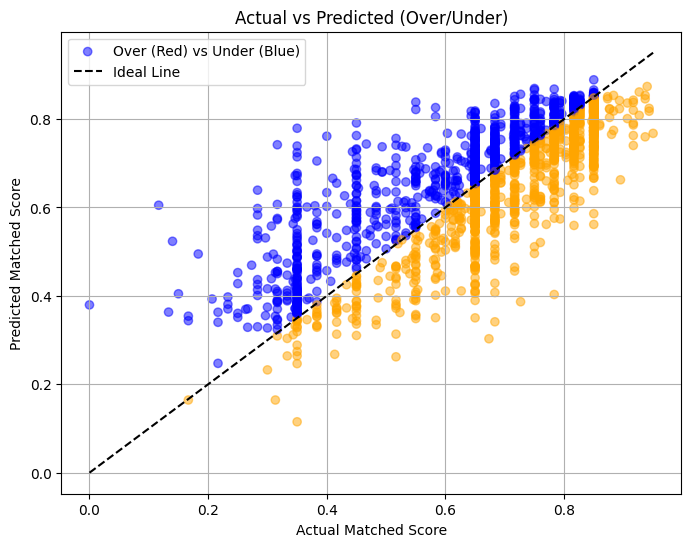

In [132]:
plt.figure(figsize=(8, 6))

# Assign colors: red if over-predicted, blue if under-predicted
colors = np.where(y_pred > y_test, 'blue', 'orange')

plt.scatter(y_test, y_pred, c=colors, alpha=0.5, label='Over (Red) vs Under (Blue)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='Ideal Line')

plt.xlabel('Actual Matched Score')
plt.ylabel('Predicted Matched Score')
plt.title('Actual vs Predicted (Over/Under)')
plt.legend()
plt.grid(True)
plt.show()

In [133]:
!pip install PyMuPDF  # If not already installed
import fitz  # PyMuPDF

def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

cv_text = extract_text_from_pdf('/content/gdrive/MyDrive/Colab Notebooks/Resume - Ali Husnain.pdf.pdf')


In [134]:
cleaned_cv_text = preprocess_text(cv_text)


In [135]:
cv_vector = tfidf.transform([cleaned_cv_text])


In [136]:
job_description = """
Job Title: Senior Full Stack PHP Engineer
Location: Remote / Virginia, United States
Job Description:
We are seeking a Senior Full Stack PHP Engineer with 7+ years of experience to join our dynamic team in building and maintaining modern web and mobile applications. The ideal candidate has a strong foundation in PHP, Laravel, JavaScript, and cloud technologies (AWS) and has demonstrated the ability to lead development teams, mentor junior engineers, and build scalable applications.

Responsibilities:
Lead the design, development, and deployment of full-stack web applications using PHP, Laravel, and JavaScript frameworks (Vue.js, Angular).

Build RESTful APIs and ensure seamless third-party integrations.

Work with relational databases including PostgreSQL, MySQL, and SQL Server.

Implement DevOps practices using AWS services (S3, EC2, RDS, Lambda) and deployment pipelines (CI/CD).

Collaborate with product managers, designers, and cross-functional teams to translate business requirements into technical solutions.

Optimize application performance through caching strategies and scalable architecture.

Mentor junior developers and conduct regular code reviews.

Requirements:
7+ years of experience as a Full Stack or PHP Developer.

Proficiency in PHP, HTML/CSS, JavaScript, SQL, and Typescript.

Hands-on experience with Laravel, Vue.js, Angular, and frontend frameworks like Bootstrap.

Familiarity with tools such as Git, Docker, Jira, and project tracking tools.

Experience with cloud infrastructure: AWS, Linux servers, nginx, and Apache.

Excellent understanding of software development life cycle (SDLC), Agile methodologies, and team collaboration.

Preferred:
Experience with payment integrations (Stripe, PayPal).

Background in building healthcare, rental management, or e-commerce platforms.

Benefits:
Flexible work hours

Remote work options

Competitive salary

Opportunity to work with innovative technologies and grow with a dynamic team
"""

In [137]:
cv_text = """
Muhammad Usman
Skilled MERN Stack Developer | React.js, Node.js, MongoDB, MySQL
...

(Your full CV content here)
"""

jd_text = """
We are looking for a MERN Stack Developer proficient in React.js and Node.js.
Experience with MongoDB, MySQL, and building scalable web applications is required.
...

(Your Job Description content here)
"""


In [138]:
# cleaned_job_description = preprocess_text(job_description)
# job_vector = tfidf.transform([cleaned_job_description])


In [142]:
# similarity_score = cosine_similarity(cv_vector, job_vector)[0][0]


In [144]:
# x_input = np.hstack((cv_vector.toarray(), np.array(similarity_score).reshape(1, -1)))


In [146]:
# predicted_score = stacked_model.predict(x_input)
# print(f"matched_score: {predicted_score[0]:.2f}")


In [ ]:
import joblib

# Save the entire stacked model
joblib.dump(stacked_model, 'candidation_recommender_model.joblib')

# Save the TF-IDF vectorizer (critical for new data preprocessing)
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')

# Later, load them:
loaded_model = joblib.load('candidation_recommender_model.joblib')
loaded_tfidf = joblib.load('tfidf_vectorizer.joblib')